# **VQE**

This notebook is part of a project . This project was sponsored by ... .

<div align="center">
  <img src="logo_sponsor1.png" alt="Sponsor 1" width="150"/>
  <img src="logo_sponsor2.png" alt="Sponsor 2" width="150"/>
  <img src="logo_sponsor3.png" alt="Sponsor 3" width="150"/>
</div>

This algorithm enables computing the gorund state of an atom/molecule.

### Prerequisites & Required Knowledge

Before diving into this notebook, make sure you're familiar with:
- Python 
- Qiskit basics
- Atom orbitals (if not, I reccomend you visit this page: https://www.chemguide.co.uk/atoms/properties/atomorbs.html)

> **Difficulty Level**: [Advantage]  
> **Estimated Time**: [2 hours]

## 1. Intruduction
As it is being said above, we try to estimate the gorund energy level of hydrogen atom in this notebook. At first, we entroduce to you the classical estimation method - Monte Carlo. This method is widely used in chemistry physics and finance. \
Just for the courious ones, we will show just a basic Monte Carlo. In practice, Diffusion Monte Carlo is used, but the computation time is even longer. We just want to show one of the main quantum advateges (shorter run time), which can be done even only with the classical Monte Carlo. 
The second part of this notebook is about the VQE (Variational Quantum Eigensolver). It is practicaly an eqivalent of Monte Carlo in quantum computing (for this certain use case).
## 2. The Classic Example of Monte Carlo: Estimating π

In [ ]:
import random 

def estimate_pi(shots):
    points = [[],[]] #to store x and y coordinates
    in_circle = 0 #to count points inside the quarter circle
    for _ in range(shots):
        # Generate random point (x, y) in the unit square
        x = random.random()
        y = random.random()
        # Store the point
        points[0].append(x)
        points[1].append(y)
        # Check if the point is inside the quarter circle
        if x*x + y*y <= 1:
            in_circle += 1

    return ((in_circle * 4) / shots), points  # Return estimated Pi and points for plotting

# Estimate Pi for different numbers of shots
for i in [1000, 10000, 100000, 1000000]:
    if i == 10000:
        pi, points = estimate_pi(i)
    else:
        pi, _ = estimate_pi(i)
    print(f"Estimated Pi with {i} shots: {pi}")

Estimated Pi with 1000 shots: 3.184
Estimated Pi with 10000 shots: 3.1348
Estimated Pi with 100000 shots: 3.13992
Estimated Pi with 1000000 shots: 3.141072


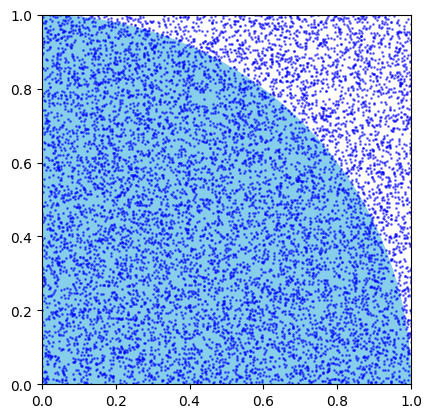

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Draw quarter circle and points
center_x = 0
center_y = 0
radius = 1
start_angle = 0
end_angle = 90

fig, ax = plt.subplots() # Create a figure and an axes.

wedge = patches.Wedge((center_x, center_y), radius, start_angle, end_angle, width=radius, fc='skyblue') # Create a quarter circle
ax.add_patch(wedge) # Add the quarter circle to the axes
ax.plot(points[0],points[1], 'o', markersize=1, alpha=0.5, color='blue') # Plot the points
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')

plt.show()

This is how it looks like.

## 2.1.  How This Works:

1. **Random Sampling**: Generate random points (x,y) in a unit square [0,1]×[0,1]
2. **Test Condition**: Check if point falls inside unit circle (x² + y² ≤ 1)
3. **Count & Scale**: Count hits, multiply by 4 to get π estimate
4. **Convergence**: More samples → better accuracy

**Key Insight**: We're approximating the integral ∫∫ $\frac{dx}{dy}$ over the circle!

---

## 2.2. General Monte Carlo Recipe:

2.2.1. **Define Your Problem**
- What quantity do you want to calculate?
- Can you express it as an expectation value or integral?

2.2.2. **Choose Sampling Strategy**
- **Importance sampling**: Sample where function is large (like |ψ|²)

2.2.3. **Generate Random Samples**
- Use appropriate random number generator
- Ensure samples are independent (or account for correlation)

2.2.4. **Evaluate Function at Each Sample**
- Calculate your quantity of interest at each random point
- Apply appropriate weights if using importance sampling

2.2.5. **Accumulate Statistics**
- Average your results: ⟨f⟩ = (1/N) Σf(xᵢ)
- Calculate error: σ = √(Var(f)/N)

 2.2.6. **Check Convergence**
- Error decreases as 1/√N
- Run multiple independent calculations
- Report: **Result ± Statistical Error**

---

## From Pi to Quantum Mechanics:

| **Pi Estimation**            | **Quantum Monte Carlo (QMC)**                 | **VQE** |
|-------------------------------|----------------------------------------------|---------|
| Random points in square       | Random electron positions                    | Angles θ as parameters in ansatz<br>(parametrized quantum circuit) |
| Test if in circle             | Calculate \|ψ(r)\|² weight                  | Compute energy with different parameters |
| Count hits                    | Evaluate local energy E_L(r)                 | Update parameters in each iteration |
| Average × 4 = π               | Weighted average = ⟨E⟩                        | Lowest found energy (ground state) |




**Same principle, different physics!**

---

## 2.2.7 Monte Carlo Advantages:
- **Dimensionality**: Works in high dimensions (3D, 6D, 3N-dimensional...)
- **Flexibility**: Can handle complex geometries and interactions  
- **Scalability**: Parallelizes easily
- **Error control**: Statistical error is well-understood

## 2.2.8 Monte Carlo Challenges:
- **Statistical noise**: Always has random error
- **Slow convergence**: Need many samples for high precision
- **Sampling efficiency**: Bad sampling wastes computational time

## 3. Hydrogen atom ground energy state - estimated classicaly. 
We are given an analytical solution:

In [17]:
E_analytical = -0.5 # hartree
a_analytical = 1.0 # Bohr radius

At first it is better to try estimate a known value. Then you know how well your parameters fit. 
Import all necessary libraries for classical solutoin:

In [ ]:
import numpy as np

We define all needed functions below:

In [19]:
def potential(r):
    """Coulomb potential for hydrogen atom: V(r) = -1/|r|"""
    distance = np.sqrt(np.dot(r, r))
    if distance == 0:
        return -float("inf")
    return -1 / distance

def psi(a, r):
    """Trial wave function: ψ(r) = exp(-a|r|)"""
    return np.exp(-a*np.sqrt(np.dot(r, r)))

def kinetic(a,r):
    """Local kinetic energy T_L = a(1/r - a/2)"""
    distance = np.sqrt(np.dot(r,r))
    if distance > 0:
        dinv = 1./distance
    else:
        print ('Warning: kinetic energy diverges at r=0')
        dinv = float("inf")
    return a * (dinv - 0.5 * a)
    return

def e_loc(a,r):
    """Local energy E_L(r) = T_L(r) + V(r)"""
    return kinetic(a,r) + potential(r)

## 3.1. WHAT THESE FUNCTIONS DO:

• **potential()** - Coulomb attractive force between proton and electron \
• **psi()** - Our trial wave function with parameter 'a' \
• **kinetic()** - Local kinetic energy derived from ψ \
• **e_loc()** - Total local energy (kinetic + potential) \
• **r** - coordinates: $$\sqrt{x^2 + y^2 + z^2}$$ \
• **a** - distance [Bohr]

**Local energy is the key to QMC: E_L(r) = $\frac{ Ĥψ(r)}{ψ(r)}$**

## 3.2. Necessary formulas
**Potential and kynetic energy**\
The given formulas are:
$$\hat{H} = \hat{T} + \hat{V}$$
The potential is:
$$ \hat{V} = \frac{1}{\sqrt{x^2 + y^2 + y^2}}$$
The local  kynetic is:
$$ \hat{T} = -\frac{1}{2}(a^2 - \frac{2a}{r})$$
**Total energy**\
The energy for the whole pupulation is defined as:
$$
E = \frac{\int \psi(r)\,\hat{H}\,\psi(r)\,dr}{\int |\psi(r)|^2\,dr} = \frac{\int E_l(r)|\psi(r)|^2\,dr}{\int |\psi(r)|^2\,dr}
$$

Discreetly, we can write the totatl enrergy of our samples as:
$$
E = \frac{\sum_{j=0}^{N}{ E_l(r_j)|\psi(r_j)|^2\,dr}}{\sum_{j=0}^{N}{ |\psi(r_j)|^2\,dr}}
$$
Essentially a weighted average of probabilities.

If you are more interested, where these formulas come from, chceck the resources at the bottom of this notebook. \
Energy levels with different a parameters:

(-2.0, 1.0)

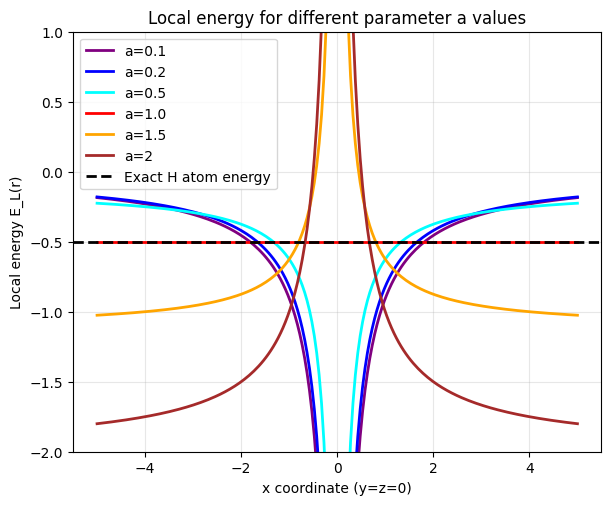

In [20]:
plt.figure(figsize=(15, 12))
# Plot of local energy along x-axis
plt.subplot(2, 2, 1)
x = np.linspace(-5, 5, 200)
x = x[x != 0] # Avoid singularity at r=0
a_vals = [0.1, 0.2, 0.5, 1., 1.5, 2]
colors = ['purple', 'blue', 'cyan', 'red', 'orange', 'brown']
for a, color in zip(a_vals, colors):
    y = []
    for r in x:
        e_val = e_loc(a, np.array([r, 0, 0]))
        # Clip extreme values for better visualization
        e_val = np.clip(e_val, -3, 2)
        y.append(e_val)
    plt.plot(x, y, label=f'a={a}', color=color, linewidth=2)
plt.axhline(y=-0.5, color='black', linestyle='--', linewidth=2,
           label='Exact H atom energy')
plt.xlabel('x coordinate (y=z=0)')
plt.ylabel('Local energy E_L(r)')
plt.title('Local energy for different parameter a values')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(-2, 1)

## From the graph we see:

• For a=1.0, E_L is most constant (≈ -0.5 hartree) \
• For other a values, E_L oscillates → worse wave function \
• Constant E_L means exact wave function (eigenfunction)

## 3.2. Statistical Error Computation

The **standard error** of the mean is computed using the formula:

$\sigma_{\text{error}} = \sqrt{\frac{\text{Var}(E_L)}{N}}$

### Step-by-step calculation:

1. **Mean energy**:
   $\langle E_L \rangle = \frac{1}{N} \sum_{i=1}^{N} E_{L,i}$

2. **Variance**:
   $\text{Var}(E_L) = \frac{1}{N-1} \sum_{i=1}^{N} (E_{L,i} - \langle E_L \rangle)^2$

3. **Standard deviation**:
   $\sigma = \sqrt{\text{Var}(E_L)}$

4. **Standard error of the mean**:
   $\sigma_{\text{error}} = \frac{\sigma}{\sqrt{N}} = \sqrt{\frac{\text{Var}(E_L)}{N}}$

where **N** is the total number of Monte Carlo samples

This follows the standard statistical formula for the **standard error of the mean** (SEM), which quantifies the uncertainty in our energy estimate due to finite sampling.

In [ ]:
def ave_error(arr):
    """Calculate average and statistical error from multiple MC runs"""
    M = len(arr) # Number of runs
    if M == 0:
        assert False, "Array is empty"
    if M == 1:
        return (arr[0], 0)
    average = np.mean(arr)
    variance = sum((arr - average)**2) / (M - 1)  # Sample variance
    error = np.sqrt(variance / M)  # Standard error of mean
    return (average, error)

## Why we need statistics:

• **Monte Carlo gives slightly different results each time**\
• **We must run multiple independent calculations**\
• **Average ± error tells us the method's precision**\
• **Error decreases as 1/√(number_of_runs)**

## How it works:

### Algorithm Steps:
1. **Pick random point r in box (-10,10)³**
2. **Calculate weight w = |ψ(r)|²**  
3. **Calculate local energy E_L(r)**
4. **Accumulate: E += w×E_L, normalization += w**
5. **Result: E = Σ(w×E_L) / Σ(w)**

### ✅ **ADVANTAGE:** 
Simple to understand

### ❌ **DISADVANTAGE:** 
Inefficient - samples regions with small |ψ|² too

In [ ]:
def MonteCarlo_uniform(a, nmax):
    """
    Monte Carlo with uniform sampling in a box
    Energy = Σ(|ψ|² × E_L) / Σ(|ψ|²)
    """
    norm = 0 # Normalization factor
    E = 0 # Energy accumulator
    for _ in range(nmax):
        # Random point in box (-5,5)³
        r = np.random.uniform(-10., 10., size=(3))
        f = psi(a, r)  # Wave function
        E_loc_val = e_loc(a, r)  # Local energy
        weight = f**2  # Weight = |ψ(r)|²
        norm += weight # Update normalization
        E += weight * E_loc_val # Update energy sum
    return E / norm # Return estimated energy

Uniform Monte Carlo...

Searching for optimal parameter a:
 a=0.80: E=-0.480745 ± 0.009225
 a=0.87: E=-0.481974 ± 0.003352
 a=0.93: E=-0.493152 ± 0.002949
 a=1.00: E=-0.500000 ± 0.000000
 a=1.07: E=-0.506116 ± 0.001717
 a=1.13: E=-0.478711 ± 0.016248
 a=1.20: E=-0.473276 ± 0.019510
 a=1.27: E=-0.489322 ± 0.029060
 a=1.33: E=-0.512901 ± 0.016460
 a=1.40: E=-0.467663 ± 0.051942


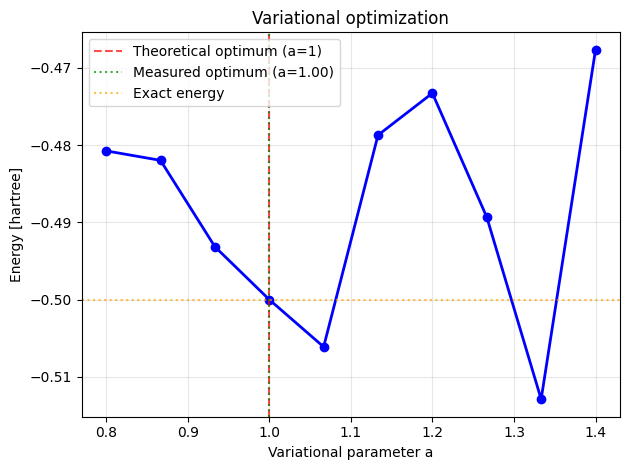

In [ ]:
print("Uniform Monte Carlo...")
a_values = np.linspace(0.8, 1.4, 10)  # Range of variational parameters to test
energies_var = []  # List to store energies for each 'a' value
print("\nSearching for optimal parameter a:")

for a_test in a_values:
   # Run Monte Carlo simulation 6 times for current 'a' value
   results = [MonteCarlo_uniform(a_test, 30000) for _ in range(6)]
   energies_a = [e for e in results]  # Extract energies from results
   E_a, dE_a = ave_error(energies_a)  # Calculate average and error
   
   # Append energy to list instead of overwriting entire array
   energies_var.append(E_a)
   
   print(f" a={a_test:.2f}: E={E_a:.6f} ± {dE_a:.6f}")

# Convert list to numpy array for vectorized operations
energies_var = np.array(energies_var)

# FIX: Find optimal parameter 'a' (not energy value)
closest_index = np.argmin(np.abs(energies_var - E_analytical))  # Index of energy closest to analytical
a_optimal = a_values[closest_index]  # Get corresponding 'a' parameter, not energy!

# Plot results
plt.plot(a_values, energies_var, 'bo-', linewidth=2, markersize=6)
plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.7,
          label='Theoretical optimum (a=1)')  # Theoretical optimum (a=1)
plt.axvline(x=a_optimal, color='green', linestyle=':', alpha=0.7,
          label=f'Measured optimum (a={a_optimal:.2f})')  # Measured optimum
plt.axhline(y=-0.5, color='orange', linestyle=':', alpha=0.7,
          label='Exact energy')  # Exact energy
plt.xlabel('Variational parameter a')  # Variational parameter a
plt.ylabel('Energy [hartree]')    # Energy [hartree]
plt.title('Variational optimization')  # Variational optimization
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"\nOptimal parameter a: {a_optimal:.2f} (closest to theoretical a=1.0)")
print(f"Analytical energy: {E_analytical:.6f} Hartree")
print(f"Measured energy: {energies_var[closest_index]:.6f} hartree")
print(f"Measured error: {np.std(energies_var):.6f} Hartree")



Optimal parameter a: 1.00 (closest to theoretical a=1.0)
Analytical energy: -0.500000 hartree
Measured energy: -0.500000 hartree
Measured error: 0.013873 hartree


## 4. Quantum problem solution
Now, we can take a look at how to solve this problem in quantum. We will dive into the VQE (Variational Quantum Eigensolver)\

# How it works:
**Algorithm Steps:**
1. **Initialize parametrized quantum circuit ansatz |ψ(θ)⟩**
2. **Measure expectation value ⟨ψ(θ)|H|ψ(θ)⟩ on quantum computer**
3. **Classical optimizer updates parameters θ to minimize energy**
4. **Repeat measurement + optimization until convergence**
5. **Result: Ground state energy ≈ $min_θ$ ⟨ψ(θ)|H|ψ(θ)⟩** \
**✅ ADVANTAGE:** \
NISQ-era friendly - shallow circuits, noise tolerant\
**❌ DISADVANTAGE:** \
Limited by ansatz expressibility and barren plateaus\

Qiskit SparsePauliOp: SparsePauliOp(['Z', 'I'],
              coeffs=[-0.5+0.j,  0. +0.j])
-0.5 hartee


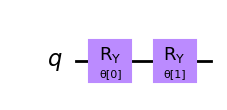

In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal

# Define Hamiltonian for H atom: H = -0.5 * Z
H = SparsePauliOp.from_list([('Z', -0.5), ('I', 0.)])
print(f"Qiskit SparsePauliOp: {H}")

# Define ansatz (with our psi wave function)
ansatz = TwoLocal(num_qubits=H.num_qubits, rotation_blocks='ry', entanglement_blocks=None, reps=1)
ansatz = ansatz.decompose()

# Set up VQE
vqe = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=SLSQP())
vqe.initial_point = [0.0] * ansatz.num_parameters  

# Compute minimum eigenvalue
result = vqe.compute_minimum_eigenvalue(H)
print(f'{result.eigenvalue} hartee')
ansatz.draw('mpl') # Draw the ansatz circuit

# 4. Monte Carlo vs VQE: Hydrogen Atom Ground State Energy

**Problem: Find E₀ of Hydrogen Atom**
**Schrödinger Equation**: $$Hψ = Eψ where H = -½∇² - 1/r$$
**Analytical Solution**: $$E₀ = -0.5 hartree, ψ₀ = e^(-r)/√πa₀³$$

---

# Monte Carlo Method
**Approach**
- **Variational Monte Carlo (VMC)** with trial wavefunction
- Random sampling in 3D space
- Statistical estimation of energy expectation value

**Trial Wavefunction**
```
ψ_trial(r; α) = $e^(-αr)$  (variational parameter α)
```
**Algorithm**
1. Sample random points r in 3D space
2. Calculate local energy: E_L(r) = [Hψ_trial(r)]/ψ_trial(r)
3. Weight by |ψ_trial(r)|²
4. Average: ⟨E⟩ = ⟨E_L⟩_ψ = ∫ |ψ|² E_L dr / ∫ |ψ|² dr
5. Optimize α to minimize ⟨E⟩

**Advantages ✅**
- **Scalable**: Linear scaling with system size
- **Flexible**: Any trial wavefunction form
- **Robust**: Works for complex many-body systems
- **Classical**: Runs on conventional computers

**Disadvantages ❌**
- **Statistical noise**: Requires many samples for accuracy
- **Ansatz limited**: Quality depends on trial wavefunction choice
- **Slow convergence**: O(1/√N) error reduction
- **Local energy variance**: Can be large for poor trial functions

---

# VQE Method

**Approach**
- **Variational Quantum Eigensolver** with parameterized quantum circuit
- Quantum state preparation and measurement
- Classical optimization of circuit parameters

**Quantum Ansatz**
```
|ψ(θ)⟩ = RY(θ₁)RZ(θ₂)|0⟩  (example 1-qubit ansatz)
```

**Algorithm**
1. Prepare parameterized quantum state |ψ(θ)⟩
2. Measure Hamiltonian expectation: ⟨ψ(θ)|H|ψ(θ)⟩
3. Classical optimizer updates θ
4. Iterate until convergence

**Advantages ✅**
- **Quantum native**: Natural for fermionic systems
- **Exact measurements**: No statistical sampling error in expectation values
- **NISQ ready**: Designed for near-term quantum devices
- **Exponential expressivity**: Can represent exponentially complex states

**Disadvantages ❌**
- **Hardware limited**: Requires quantum computer
- **Circuit depth**: Shallow circuits limit expressivity
- **Measurement overhead**: Many measurements needed for complex Hamiltonians
- **Barren plateaus**: Optimization can get stuck

---

**Comparison for Hydrogen Atom**

| **Aspect** | **Monte Carlo** | **VQE** |
|------------|-----------------|---------|
| **Hardware** | Classical CPU | Quantum computer + Classical optimizer |
| **Scaling** | Polynomial (favorable) | Exponential expressivity |
| **Accuracy** | Limited by trial function & statistics | Limited by ansatz & quantum noise |
| **Implementation** | Straightforward | Complex quantum control |
| **Error Sources** | Statistical fluctuations | Quantum decoherence, gate errors |
| **Current Status** | Mature, production-ready | Research/development stage |

**Practical Considerations**

**For Hydrogen Atom (1 electron):**
- **Monte Carlo**: Overkill but reliable, well-established
- **VQE**: Educational value, proof-of-concept for larger systems

**For Larger Systems:**
- **Monte Carlo**: Remains tractable, proven for many-body physics
- **VQE**: Potential quantum advantage, limited by current hardware

**Conclusion**
For hydrogen atom specifically, **Monte Carlo is more practical** due to hardware maturity. However, **VQE demonstrates principles** that become advantageous for larger molecular systems where classical methods face exponential scaling challenges. And is much better for larger molecules.

# 4.1. Variational Quantum Eigensolver (VQE) - Mathematical Description

## **Problem Setup**
Given Hamiltonian as SparsePauliOp:
```
H = -0.5·Z + 0.0·I
```
Find minimum eigenvalue: **E₀ = $min_θ$ ⟨ψ(θ)|H|ψ(θ)⟩**

## **Ansatz: TwoLocal Circuit**
Parameterized quantum circuit with RY rotations:
```
|ψ(θ)⟩ = RY(θ)|0⟩
```
For 1-qubit system: U(θ) = RY(θ) = e^(-iθY/2)

## **State Representation**
```
|ψ(θ)⟩ = cos(θ/2)|0⟩ + sin(θ/2)|1⟩
```

## **Expectation Value Calculation**
```
⟨ψ(θ)|H|ψ(θ)⟩ = -0.5⟨ψ(θ)|Z|ψ(θ)⟩ + 0.0⟨ψ(θ)|I|ψ(θ)⟩= -0.5(cos²(θ/2) - sin²(θ/2) = -0.5·cos(θ))
```

## **Optimization Problem**
SLSQP minimizes:
```
C(θ) = -0.5·cos(θ)
```
Starting from θ₀ = 0.0

## **Analytical Solution**
```
dC/dθ = 0.5·sin(θ) = 0  →  θ* = 0 or π
C(0) = -0.5,  C(π) = 0.5
```
**Minimum: θ* = 0, E₀ = -0.5**\

## **Qiskit Implementation**
- **Estimator**: Computes ⟨ψ(θ)|H|ψ(θ)⟩ via quantum measurement
- **SLSQP**: Sequential Least-Squares Programming optimizer
- **Result**: Converges to eigenvalue ≈ -0.5 hartree

### Expectation Value of the Hamiltonian

In quantum computing, we often measure the **expectation value** of a Hamiltonian $$H$$ for a given quantum state $$|\psi\rangle$$. The Hamiltonian can be decomposed into a sum of Pauli operators $$P_\lambda$$ with coefficients $$\lambda$$

$$
H = \sum_\lambda \lambda P_\lambda
$$

The expectation value of $$H$$ is then:

$$
E(H) = \sum_\lambda \lambda \, p(\lambda) 
       = \sum_\lambda \lambda \, \langle \psi | P_\lambda | \psi \rangle
       = \langle \psi | \sum_\lambda \lambda P_\lambda | \psi \rangle
       = \langle \psi | H | \psi \rangle
$$

- $p(\lambda) = \langle \psi | P_\lambda | \psi \rangle$ is the probability-weighted contribution of each Pauli term.  
- Measuring each Pauli term individually and summing with the coefficients $\lambda$ gives the **total energy expectation value**.  

---

✅ In VQE, this is exactly how the quantum computer outputs an estimate of the energy for a given ansatz state.




On Linux or Mac run this cell:

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
  0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])
Electronic energy: -1.857275 Ha
Nuclear repulsion: 0.719969 Ha
Total energy:     -1.137306 Ha


/Users/ema/Documents/Python/quantum/Quantum-Examples/qiskit_env/lib/python3.13/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


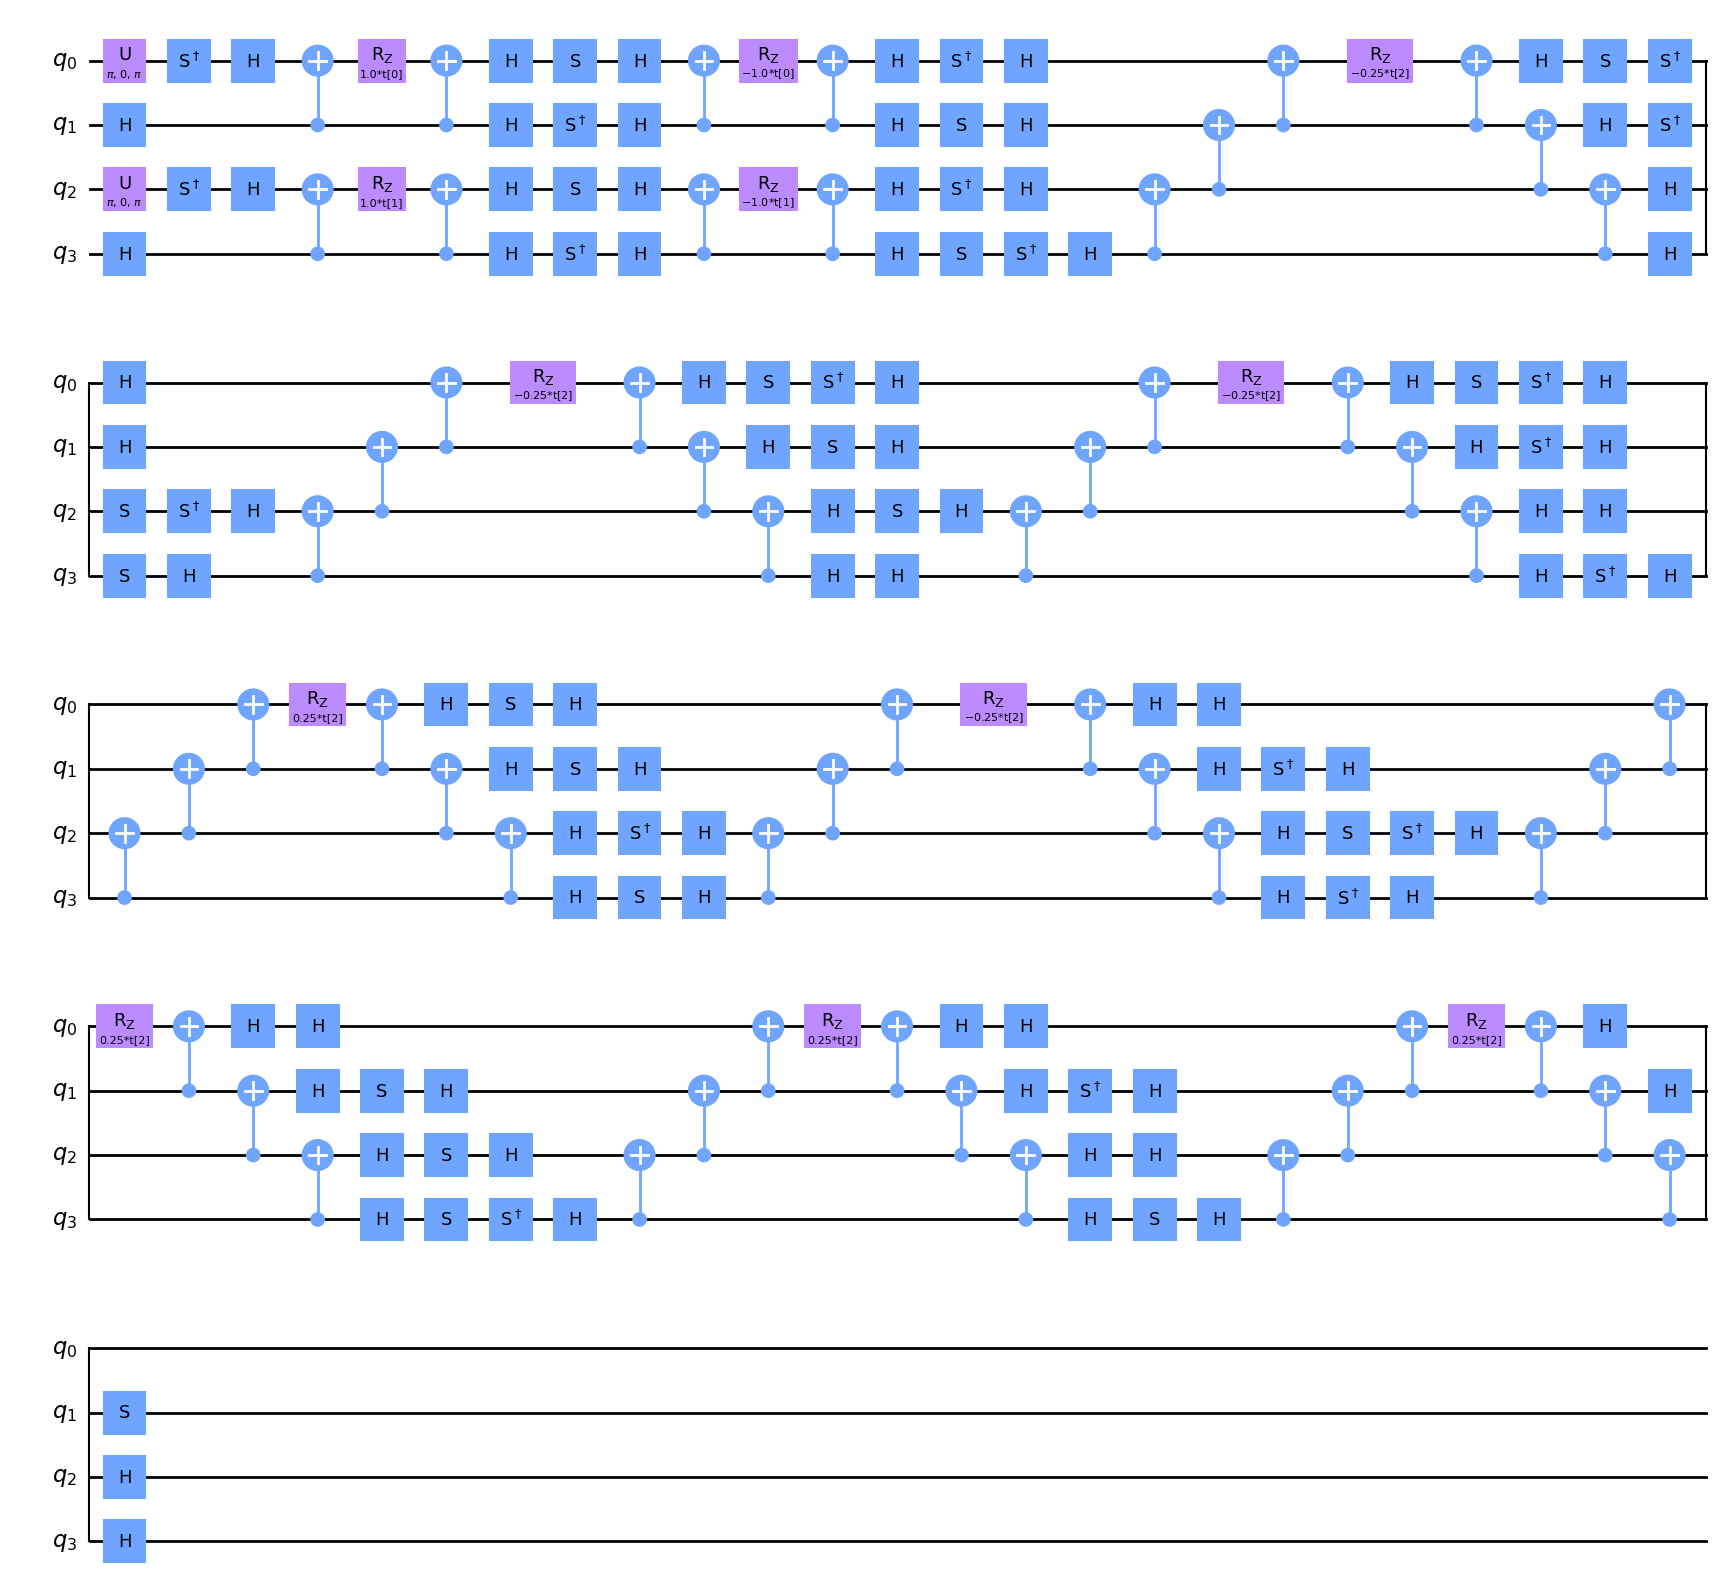

In [28]:
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Molecular system
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
es_problem = driver.run()

# Fermionic Hamiltonian
ferm_hamiltonian = es_problem.hamiltonian.second_q_op()

# Map to qubits
mapper = JordanWignerMapper()
qubit_op = mapper.map(ferm_hamiltonian)
print(qubit_op)

# Ansatz: UCCSD with HF initial state
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

# Optional: decompose gates for clarity
ansatz = ansatz.decompose().decompose().decompose()

# VQE setup
vqe = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=SLSQP())
vqe.initial_point = [0.0] * ansatz.num_parameters

# Run VQE
result = vqe.compute_minimum_eigenvalue(qubit_op)

# Extract results
E_elec = result.eigenvalue.real
E_total = E_elec + es_problem.nuclear_repulsion_energy

print(f"Electronic energy: {E_elec:.6f} Ha")
print(f"Nuclear repulsion: {es_problem.nuclear_repulsion_energy:.6f} Ha")
print(f"Total energy:     {E_total:.6f} Ha")

# Draw ansatz
ansatz.draw("mpl")


On Windows run this cell:
{Or you can install the pycsf lib into a docker - it is not supported for Windows. The result from the code cell below will be a bit less accurate.}

In [27]:
# from qiskit_nature.second_q.operators import FermionicOp
# from qiskit_algorithms import VQE
# from qiskit_algorithms.optimizers import SLSQP
# from qiskit.primitives import Estimator
# from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
# from qiskit_nature.second_q.mappers import JordanWignerMapper
# from qiskit.quantum_info import SparsePauliOp

# from qiskit.quantum_info import SparsePauliOp

# nuclear_repulsion_energy = 0.735

# mapper = JordanWignerMapper()

# qubit_op = SparsePauliOp(
#     ['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'ZIII', 'ZIIZ', 
#      'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
#     coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.12091263+0.j,
#             0.17218393+0.j,  0.16892754+0.j, -0.22575349+0.j,  0.16614543+0.j,
#             0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
#             0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j]
# )

# # Ansatz: UCCSD with HF initial state
# ansatz = UCCSD(
#     2,
#     (1, 1),
#     mapper,
#     initial_state=HartreeFock(
#         2,
#         (1, 1),
#         mapper,
#     ),
# )

# # Optional: decompose gates for clarity
# ansatz = ansatz.decompose().decompose()

# # VQE setup
# vqe = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=SLSQP())
# vqe.initial_point = [0.0] * ansatz.num_parameters

# # Run VQE
# result = vqe.compute_minimum_eigenvalue(qubit_op)

# # Extract results

# E_elec = result.eigenvalue.real
# E_total = E_elec + nuclear_repulsion_energy

# print(f"Electronic energy: {E_elec:.6f} Ha")
# print(f"Nuclear repulsion: {nuclear_repulsion_energy:.6f} Ha")
# print(f"Total energy:     {E_total:.6f} Ha")

# # Draw ansatz
# ansatz.draw("mpl")



## 4.2. H₂ Molecule VQE - Code Explanation

# 4.2.1. Molecular System Setup
* Note - the SparePauliOp does basically the as as PyCSF, but the installation f pycsf lib can be a little complicated on Windows. (You can install it, of course). The Pycsf is a little more efficient though, 

```python
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",  # Two H atoms 0.735 Å apart
    basis="sto3g",                # Minimal basis set
    charge=0,                     # Neutral molecule
    spin=0,                       # Singlet state
    unit=DistanceUnit.ANGSTROM,
)
```

*The MockH2Driver does basically the same.
**Creates H₂ molecule at experimental bond length using quantum chemistry driver**

# 4.2.2. Electronic Structure Problem
```python
es_problem = driver.run()
ferm_hamiltonian = es_problem.hamiltonian.second_q_op()
```
**Generates molecular Hamiltonian in fermionic operators:**
- **2 electrons** in **2 spatial orbitals** (4 spin-orbitals total)
- Includes kinetic energy, nuclear-electron, and electron-electron terms

# 4.2.3. Qubit Mapping
```python
mapper = JordanWignerMapper()
qubit_op = mapper.map(ferm_hamiltonian)
```
**Converts fermionic operators → Pauli operators:**
- Fermionic creation/annihilation → combinations of X, Y, Z
- Preserves anticommutation relations
- Results in **4-qubit** Hamiltonian

# 4.2.4. Quantum Ansatz: UCCSD
```python
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,  # 2 orbitals
    es_problem.num_particles,         # 2 electrons
    mapper,
    initial_state=HartreeFock(...)    # |01⟩⊗|10⟩ configuration
)
```
**Unitary Coupled Cluster Singles & Doubles:**
- **Initial state**: Hartree-Fock (mean-field approximation) = creates "starting point" for furher computation
- **Excitations**: Single and double electron promotions
- **Unitary**: $e^(T-T†)$ ensures wavefunction normalization (electron excitation)

# 4.2.5. VQE Optimization
```python
vqe = VQE(estimator=Estimator(), ansatz=ansatz, optimizer=SLSQP())
result = vqe.compute_minimum_eigenvalue(qubit_op)
```

# Mathematical Process:
1. **Prepare state**: $$|ψ(θ)⟩ = UCCSD(θ)|HF⟩$$
2. **Measure energy**: $$E(θ) = ⟨ψ(θ)|H|ψ(θ)⟩$$
3. **Classical optimization**: $$θ_{k+1} = θ_k - η∇E(θ_k)$$ 
$$ θ_k - vector of parameters; ∇E - gradient of energy, η - learning rate$$
4. **Iterate** until convergence

# 4.2.6. Expected Result
**Ground state energy ≈ -1.137 hartree**
- Includes electron correlation beyond Hartree-Fock
- Should match experimental/high-level theory within chemical accuracy (~1 kcal/mol)

**Physical Significance**
This demonstrates **quantum advantage** for chemistry:
- Classical computers scale exponentially with system size
- Quantum computers naturally handle fermionic wavefunctions
- UCCSD captures essential electron correlation effects

# Nuclear Repulsion Energy

In quantum chemistry, the electronic Hamiltonian only accounts for the motion and interactions of the electrons.  
However, the nuclei also interact with each other through classical Coulomb repulsion, and this must be added separately to obtain the **total molecular energy**.

The nuclear repulsion energy is given by:


   $$E_\text{nuc} = \sum_{A<B} \frac{Z_A Z_B}{R_{AB}}$$


where:

- $Z_A$, $Z_B$ are the nuclear charges (for hydrogen: \(Z=1\)),
- $R_{AB}$ is the internuclear distance in **bohr**.

---

**Example: H₂ molecule at 0.735 Å**

1. Convert distance:  


  $$ 0.735\ \text{Å} \approx 1.389\ a_0$$


2. Both nuclei are protons $Z_A$ = $Z_B$ = 1.
3. Coulomb repulsion: 
$$
   E_\text{nuc} = \frac{1 \cdot 1}{1.389} \approx 0.72\ \text{Hartree}
$$

---

Therefore, the **total molecular energy** is:

$$
E_\text{total} = E_\text{electronic} + E_\text{nuc}
$$

For H₂ at equilibrium bond length in STO-3G:
- Electronic energy:  -1.857 Hartee 
- Nuclear repulsion: +0.720 Hartee 
- **Total energy**: -1.137 Hartee

# VQE Circuit Gates

**What is this circuit doing?**
This quantum circuit is trying to find the lowest energy state of a hydrogen molecule (H₂). Think of it like finding the most stable way two hydrogen atoms can stick together.

**The Simple Gate Types**

**Rotation Gates (like Rz)**
- **What they do**: Rotate the quantum state (like turning a dial)
- **Why we need them**: The computer adjusts these "dials" to find the best energy
- **In the circuit**: **Rz(t[0])**, **Rz(t[1])**, **Rz(t[2])** - the **t** values are what get optimized

**Connection Gates (CNOT)**
- **What they do**: Connect two qubits - entaglement
- **Why we need them**: Electrons in molecules influence each other

**Preparation Gates (H, U3, √X)**
- **What they do**: Set up the starting point and change between different ways of measuring
- **Why we need them**: We need the right starting state and measurement setup
- **In the circuit**: H gates, U3 gates, √X gates

**The Big Picture**
1. **Start**: Prepare the molecule in a basic state (like electrons in separate atoms)
2. **Adjust**: Turn the rotation "dials" (parameters) to different settings  
3. **Connect**: Let the electrons "talk" to each other through connection gates
4. **Measure**: Find out what energy this gives us
5. **Repeat**: Try different dial settings until we find the lowest energy

**Why 4 qubits?**
Each qubit represents one "slot" where an electron can be:
- Qubit 0: Electron with ↑ spin in orbital 1
- Qubit 1: Electron with ↓ spin in orbital 1  
- Qubit 2: Electron with ↑ spin in orbital 2
- Qubit 3: Electron with ↓ spin in orbital 2

**The Result**
After many tries with different dial settings, the computer finds the arrangement that gives the lowest energy - this tells us how strongly the two hydrogen atoms bind together!

## 5. Summary

In this notebook, we explored VQE and its andvantages. We did comparsion of the cassical and quatum method for estimating the ground energy state for hydrogen atom. (And than showed, how we would do it for a bigger molecule. )
**Key Takeaway**: [One sentence summary of the most important learning]


### 5.1. Citations
- Classical version inspo: https://trex-coe.github.io/qmc-lttc-2023/index.html#undefined 
- Physics content: https://en.wikipedia.org/wiki/Kinetic_energy?utm_source=chatgpt.com 
                https://en.wikipedia.org/wiki/Momentum_operator?utm_source=chatgpt.com \
- Maths content: https://en.wikipedia.org/wiki/Laplace_operator 
- Quantum guide: https://qiskit-community.github.io/qiskit-nature/migration/0.6_b_mes_factory.html \
https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html
### 5.2. Get Involved

#### **Found an Issue?**
- Report bugs or suggest improvements: [GitHub Issues](https://github.com/mforgo/Quantum-Examples/issues)
- Contribute to the codebase: [Contributing guidelines link](https://github.com/mforgo/Quantum-Examples/blob/master/README.md)

#### **Contact & Feedback**
...

> *Author: [Ema Žánová] | Last Updated: [20.08.2025] | Version: [1.0] | License: [License Type]*
